Below is a Pipeline that creates, 1d, 1week, 1 month momentum as factors and then filters the 2 tickers 'IBM' and 'AAPL'. You can use a so called "CustomFilter" to create a filter based on SIDs for the tickers (you have to use the 'symbols('AAPL').sid' notation to get the respective SIDs). You can just this notebook if you like, simply add your tickers below in the pipeline definition:

In [56]:
from quantopian.pipeline import CustomFilter
class SidInList(CustomFilter):
    """
    Filter returns True for any SID included in parameter tuple passed at creation.
    """    
    inputs = []
    window_length = 1
    params = ('sid_list',)

    def compute(self, today, assets, out, sid_list):
        out[:] = np.in1d(assets, sid_list)   

In [57]:
# Pipeline imports
from quantopian.pipeline import Pipeline, CustomFilter
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import  StaticAssets
from quantopian.pipeline.factors import Returns

# Pipeline definition
def  make_pipeline():    
 
    include_filter = SidInList(sid_list = (symbols('AAPL').sid, symbols('IBM'))) # SID for APPL and SPY

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    return Pipeline(
        columns={
            'returns_1d': Returns(window_length=2),
            'returns_1w': Returns(window_length=6),
            'returns_1m': Returns(window_length=22),
        },
        screen=include_filter
    )

In [58]:
# Import run_pipeline method
from quantopian.research import run_pipeline
import numpy as np

# Specify a time range to evaluate
period_start = '2016-01-01'
period_end = '2016-02-01'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In [59]:
pipeline_output.head()

returns_1d  returns_1m  \
2016-01-04 00:00:00+00:00 Equity(24 [AAPL])    -0.019474   -0.103128   
                          Equity(3766 [IBM])   -0.012631   -0.026189   
2016-01-05 00:00:00+00:00 Equity(24 [AAPL])     0.000950   -0.094325   
                          Equity(3766 [IBM])   -0.011920   -0.027193   
2016-01-06 00:00:00+00:00 Equity(24 [AAPL])    -0.024969   -0.108507   

                                              returns_1w  
2016-01-04 00:00:00+00:00 Equity(24 [AAPL])    -0.031121  
                          Equity(3766 [IBM])   -0.006643  
2016-01-05 00:00:00+00:00 Equity(24 [AAPL])    -0.024993  
                          Equity(3766 [IBM])   -0.016495  
2016-01-06 00:00:00+00:00 Equity(24 [AAPL])    -0.038570

In addition to sentiment data, we will need pricing data for all assets present in this period. We can easily get a list of these assets from our pipeline output's index, and pass that list to `prices` to get the pricing data we need:

In [60]:
# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.get_level_values(1).unique() 

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

Now we can use Quantopian's open source factor analysis tool, [Alphalens](https://www.quantopian.com/lectures/factor-analysis-with-alphalens), to test the quality of our selection strategy. First, let's combine our factor and pricing data using get_clean_factor_and_forward_returns. This function classifies our factor data into quantiles and computes forward returns for each security for multiple holding periods. We will separate our factor data into 2 quantiles (the top and bottom half), and uses 1 day holding periods:

In [61]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['returns_1m'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,),
)

# Display first 5 rows
factor_data.head(5)

Dropped 5.0% entries from factor data: 5.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D    factor  \
date                      asset                                    
2016-01-04 00:00:00+00:00 Equity(24 [AAPL])  -0.024969 -0.103128   
                          Equity(3766 [IBM]) -0.000736 -0.026189   
2016-01-05 00:00:00+00:00 Equity(24 [AAPL])  -0.019474 -0.094325   
                          Equity(3766 [IBM]) -0.004638 -0.027193   
2016-01-06 00:00:00+00:00 Equity(24 [AAPL])  -0.041311 -0.108507   

                                              factor_quantile  
date                      asset                                
2016-01-04 00:00:00+00:00 Equity(24 [AAPL])                 1  
                          Equity(3766 [IBM])                2  
2016-01-05 00:00:00+00:00 Equity(24 [AAPL])                 1  
                          Equity(3766 [IBM])                2  
2016-01-06 00:00:00+00:00 Equity(24 [AAPL])                 1

Having our data in this format allows us to use several of Alphalens's analysis and plotting tools:

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.183732,-0.090660,-0.126338,0.026448,19,50.0
2,-0.124801,-0.022874,-0.057300,0.033448,19,50.0


Returns Analysis


,1D
Ann. alpha,-0.556
beta,-0.072
Mean Period Wise Return Top Quantile (bps),-29.066
Mean Period Wise Return Bottom Quantile (bps),29.066
Mean Period Wise Spread (bps),-58.132


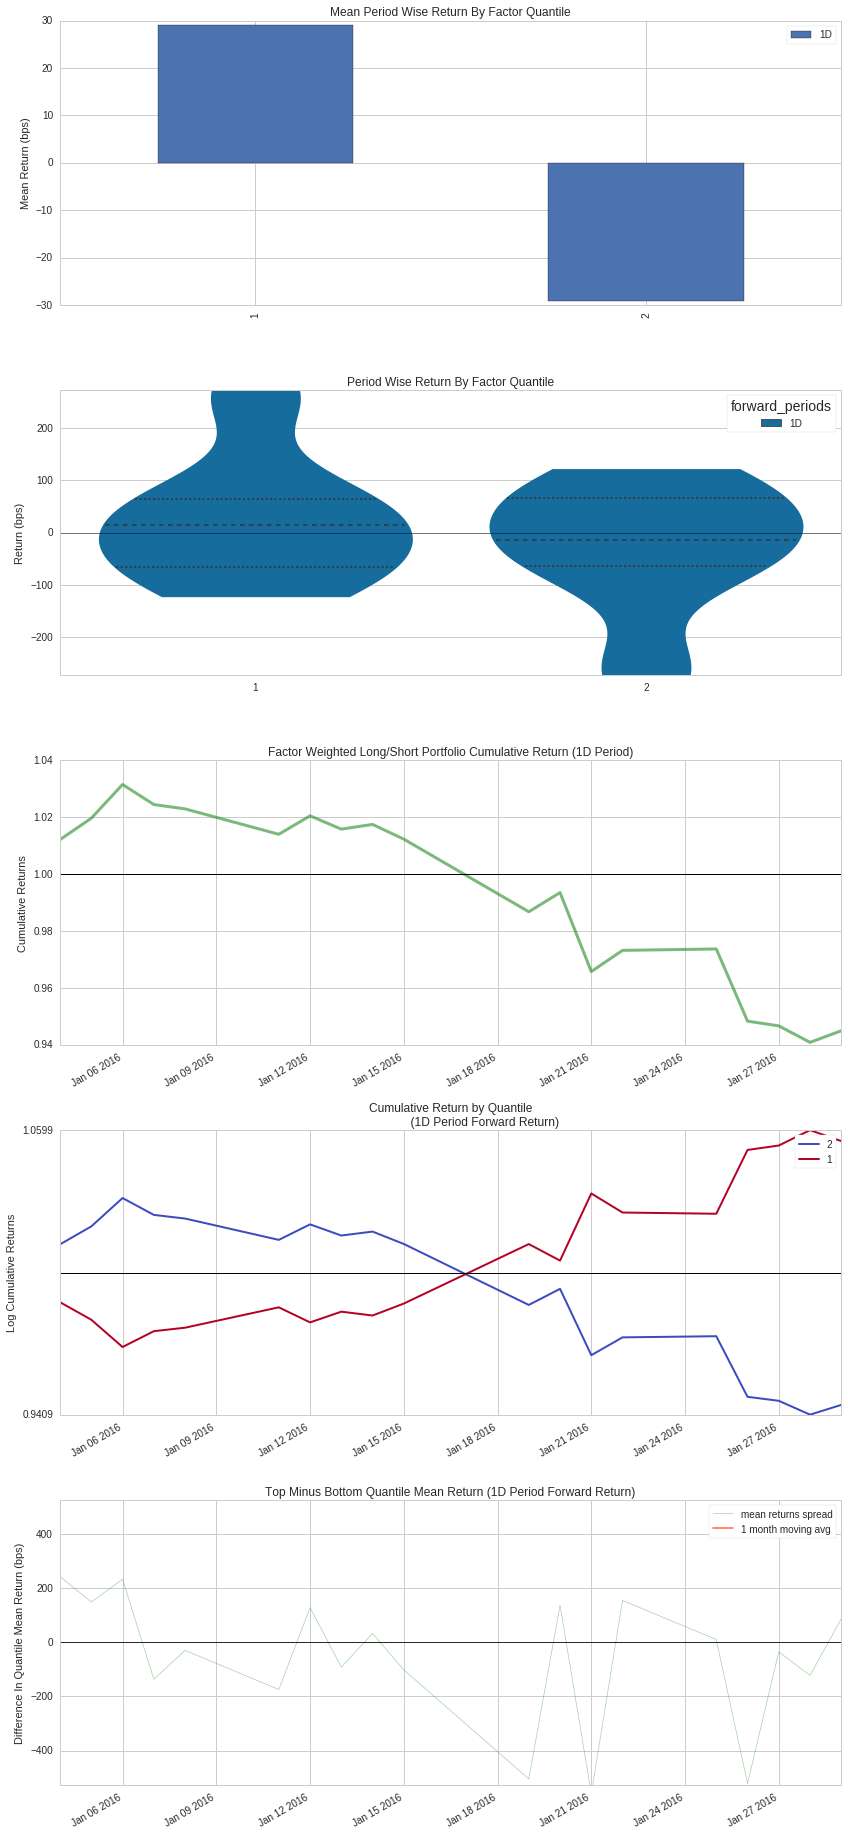

Information Analysis


,1D
IC Mean,-0.053
IC Std.,1.026
Risk-Adjusted IC,-0.051
t-stat(IC),-0.224
p-value(IC),0.826
IC Skew,0.105
IC Kurtosis,-1.989


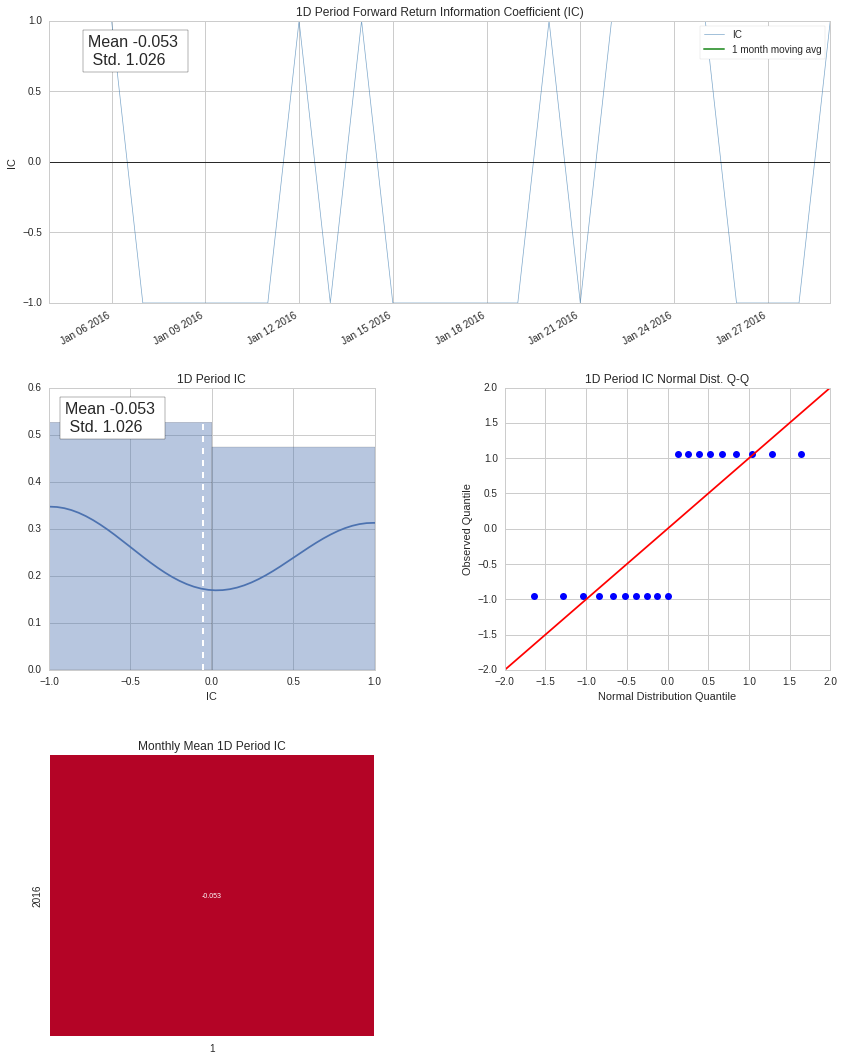

Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.111
Quantile 2 Mean Turnover,0.111


,1D
Mean Factor Rank Autocorrelation,0.778


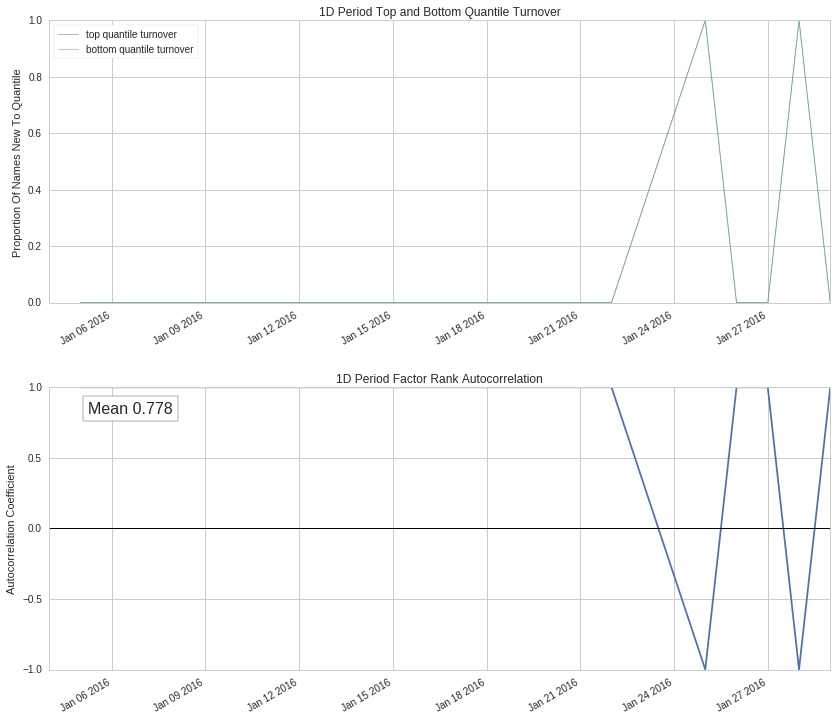

In [62]:
import alphalens
alphalens.tears.create_full_tear_sheet(factor_data, by_group=False);